## Data Extraction

In [196]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('owid-energy-data.csv')
df.head()

country  year iso_code  population  gdp  biofuel_cons_change_pct  \
0  Afghanistan  1900      AFG   4832414.0  NaN                      NaN   
1  Afghanistan  1901      AFG   4879685.0  NaN                      NaN   
2  Afghanistan  1902      AFG   4935122.0  NaN                      NaN   
3  Afghanistan  1903      AFG   4998861.0  NaN                      NaN   
4  Afghanistan  1904      AFG   5063419.0  NaN                      NaN   

   biofuel_cons_change_twh  biofuel_cons_per_capita  biofuel_consumption  \
0                      NaN                      NaN                  NaN   
1                      NaN                      NaN                  NaN   
2                      NaN                      NaN                  NaN   
3                      NaN                      NaN                  NaN   
4                      NaN                      NaN                  NaN   

   biofuel_elec_per_capita  ...  solar_share_elec  solar_share_energy  \
0                      NaN  ...               NaN                 NaN   
1                      NaN  ...               NaN                 NaN   
2                      NaN  ...               NaN                 NaN   
3                      NaN  ...               NaN                 NaN   
4                      NaN  ...               NaN                 NaN   

   wind_cons_change_pct  wind_cons_change_twh  wind_consumption  \
0                   NaN                   NaN               NaN   
1                   NaN                   NaN               NaN   
2                   NaN                   NaN               NaN   
3                   NaN                   NaN               NaN   
4                   NaN                   NaN               NaN   

   wind_elec_per_capita  wind_electricity  wind_energy_per_capita  \
0                   NaN               NaN                     NaN   
1                   NaN               NaN                     NaN   
2                   NaN               NaN                     NaN   
3                   NaN               NaN                     NaN   
4                   NaN               NaN                     NaN   

   wind_share_elec  wind_share_energy  
0              NaN                NaN  
1              NaN                NaN  
2              NaN                NaN  
3              NaN                NaN  
4              NaN                NaN  

[5 rows x 129 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21890 entries, 0 to 21889
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.5+ MB


## Data Visualisation - choropleth for general metrics

In [5]:
# import plotly
import plotly.express as px

#countries.csv is extracted from online where it contains ISO 3166-1 alpha-3 codes of 193 recognised countries
iso_codes = pd.read_csv('countries.csv')
alpha3 = iso_codes['alpha3'].apply(str.upper).unique()
print("Recognised countries: ", len(alpha3))

iso_countries = df[df['iso_code'].isin(alpha3)]['iso_code'].unique()
print("Countries in dataframe: ",len(iso_countries))

Recognised countries:  193
Countries in dataframe:  187


In [6]:
# make alpha3 into a dataframe (from a numpy array) to check for missing countries
df_alpha3 = pd.DataFrame(alpha3)
mis_countries = df_alpha3[~df_alpha3.isin(iso_countries)].dropna()
mis_countries

0
3    AND
99   LIE
108  MHL
114  MCO
132  PLW
148  SMR

The officially recognised countries (based on ISO 3166-1 alpha3 codes) not included are: **Andorra, Liechtenstein, Marshall Islands, Monaco, Palau and San Marino**

We don't need to include their data as they are relatively small countries

In [7]:
# initialise countries dataframe for the 187 countries identified
country_data = df[df['iso_code'].isin(iso_countries)].copy()

# exclude year 2022 as visual inspection on excel file shows many missing countries
country_data = country_data[country_data['year'] < 2022]
country_data.head()

country  year iso_code  population  gdp  biofuel_cons_change_pct  \
0  Afghanistan  1900      AFG   4832414.0  NaN                      NaN   
1  Afghanistan  1901      AFG   4879685.0  NaN                      NaN   
2  Afghanistan  1902      AFG   4935122.0  NaN                      NaN   
3  Afghanistan  1903      AFG   4998861.0  NaN                      NaN   
4  Afghanistan  1904      AFG   5063419.0  NaN                      NaN   

   biofuel_cons_change_twh  biofuel_cons_per_capita  biofuel_consumption  \
0                      NaN                      NaN                  NaN   
1                      NaN                      NaN                  NaN   
2                      NaN                      NaN                  NaN   
3                      NaN                      NaN                  NaN   
4                      NaN                      NaN                  NaN   

   biofuel_elec_per_capita  ...  solar_share_elec  solar_share_energy  \
0                      NaN  ...               NaN                 NaN   
1                      NaN  ...               NaN                 NaN   
2                      NaN  ...               NaN                 NaN   
3                      NaN  ...               NaN                 NaN   
4                      NaN  ...               NaN                 NaN   

   wind_cons_change_pct  wind_cons_change_twh  wind_consumption  \
0                   NaN                   NaN               NaN   
1                   NaN                   NaN               NaN   
2                   NaN                   NaN               NaN   
3                   NaN                   NaN               NaN   
4                   NaN                   NaN               NaN   

   wind_elec_per_capita  wind_electricity  wind_energy_per_capita  \
0                   NaN               NaN                     NaN   
1                   NaN               NaN                     NaN   
2                   NaN               NaN                     NaN   
3                   NaN               NaN                     NaN   
4                   NaN               NaN                     NaN   

   wind_share_elec  wind_share_energy  
0              NaN                NaN  
1              NaN                NaN  
2              NaN                NaN  
3              NaN                NaN  
4              NaN                NaN  

[5 rows x 129 columns]

In [8]:
# determine the metrics we want to use for choropleths
country_metrics = ['population', 'greenhouse_gas_emissions', 'fossil_fuel_consumption', 'renewables_consumption', "fossil_elec_per_capita", 'renewables_elec_per_capita']

# create a dictionary to store the upper limits for each column
upper_limits = {}

# Loop over each column and calculate the truncated mean and standard deviation
for column in country_metrics:
    country_data1 = country_data.dropna()
    threshold = np.percentile(country_data1[column], 65)
    truncated_data = country_data1[country_data1[column] <= threshold][column]
    truncated_mean = np.mean(truncated_data)
    truncated_std = np.std(truncated_data)

    # Set the upper limit for the color scale to be 3 standard deviations above the truncated mean
    upper_limits[column] = truncated_mean + 3 * truncated_std

upper_limits

{'population': 106228535.56634855,
 'greenhouse_gas_emissions': 192.06582674836483,
 'fossil_fuel_consumption': 3226.6705383816916,
 'renewables_consumption': 614.5476433155637,
 'fossil_elec_per_capita': 6223.304386823099,
 'renewables_elec_per_capita': 2082.1649752169883}

### Choropleth for Population (starts from 1900)

In [9]:
fig = px.choropleth(data_frame=country_data,
                    locations="iso_code",
                    color='population',
                    animation_frame='year',
                    color_continuous_scale='Reds',
                    center={"lat": 0, "lon": 0},
                    width = 1200,
                    height = 800,
                    range_color=(0,upper_limits['population']))
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig.show()

### Choropleth for Greenhouse Gas Emissions (starts from 2000)

In [10]:
# start from year 2000
fig = px.choropleth(data_frame=country_data,
                    locations="iso_code",
                    color='greenhouse_gas_emissions',
                    animation_frame='year',
                    color_continuous_scale='Reds',
                    center={"lat": 0, "lon": 0},
                    width = 1200,
                    height = 800,
                    range_color=(0,upper_limits['greenhouse_gas_emissions']))
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 150
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 10
fig.show()

### Choropleth for Fossil Fuel Electricity per capita (starts from 1985)

In [11]:
# start from year 2000
fig = px.choropleth(data_frame=country_data,
                    locations="iso_code",
                    color='fossil_elec_per_capita',
                    animation_frame='year',
                    color_continuous_scale='Reds',
                    center={"lat": 0, "lon": 0},
                    width = 1200,
                    height = 800,
                    range_color=(0,upper_limits['fossil_elec_per_capita']))
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 10
fig.show()

## Data Cleaning - trend lines for continent data

We compare continents for energy usage rather than countries as we are concerned with the overall energy usage.

In addition, countries' economic states vary a lot and time-series forecasting may not work for these countries realistically.

In [12]:
continents = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania']
df1 = df[df['country'].isin(continents)]
df1.head()

country  year iso_code   population  gdp  biofuel_cons_change_pct  \
122  Africa  1900      NaN  138827369.0  NaN                      NaN   
123  Africa  1901      NaN  139097937.0  NaN                      NaN   
124  Africa  1902      NaN  139567767.0  NaN                      NaN   
125  Africa  1903      NaN  140074606.0  NaN                      NaN   
126  Africa  1904      NaN  140595545.0  NaN                      NaN   

     biofuel_cons_change_twh  biofuel_cons_per_capita  biofuel_consumption  \
122                      NaN                      NaN                  NaN   
123                      NaN                      NaN                  NaN   
124                      NaN                      NaN                  NaN   
125                      NaN                      NaN                  NaN   
126                      NaN                      NaN                  NaN   

     biofuel_elec_per_capita  ...  solar_share_elec  solar_share_energy  \
122                      NaN  ...               NaN                 NaN   
123                      NaN  ...               NaN                 NaN   
124                      NaN  ...               NaN                 NaN   
125                      NaN  ...               NaN                 NaN   
126                      NaN  ...               NaN                 NaN   

     wind_cons_change_pct  wind_cons_change_twh  wind_consumption  \
122                   NaN                   NaN               NaN   
123                   NaN                   NaN               NaN   
124                   NaN                   NaN               NaN   
125                   NaN                   NaN               NaN   
126                   NaN                   NaN               NaN   

     wind_elec_per_capita  wind_electricity  wind_energy_per_capita  \
122                   NaN               NaN                     NaN   
123                   NaN               NaN                     NaN   
124                   NaN               NaN                     NaN   
125                   NaN               NaN                     NaN   
126                   NaN               NaN                     NaN   

     wind_share_elec  wind_share_energy  
122              NaN                NaN  
123              NaN                NaN  
124              NaN                NaN  
125              NaN                NaN  
126              NaN                NaN  

[5 rows x 129 columns]

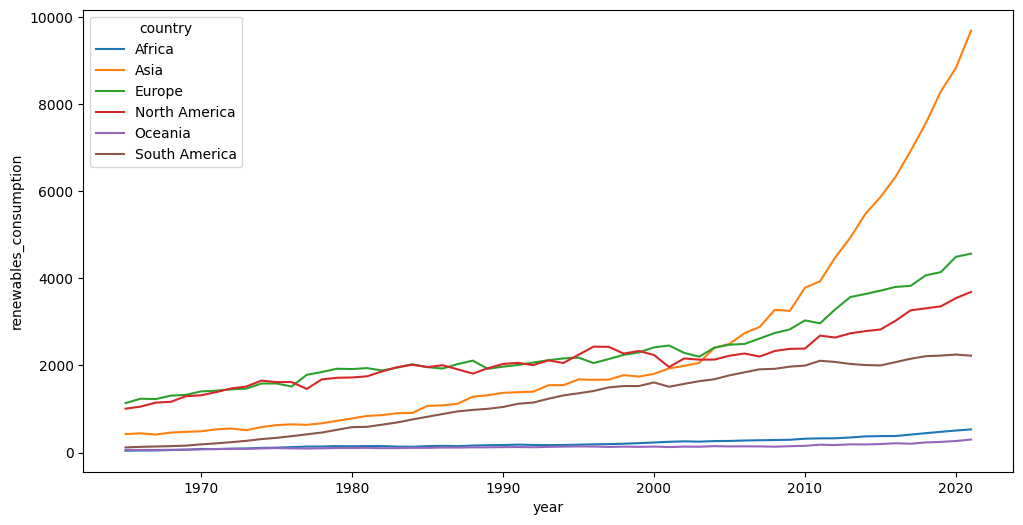

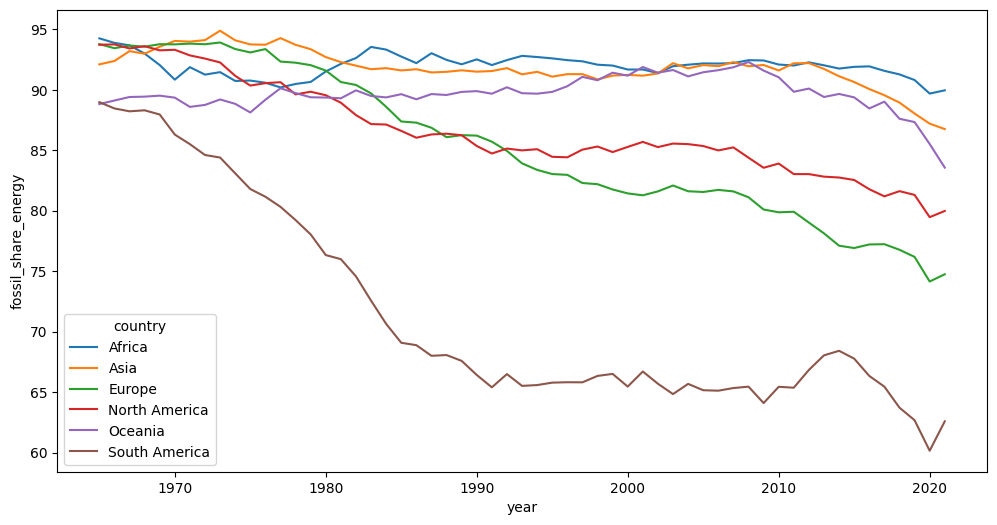

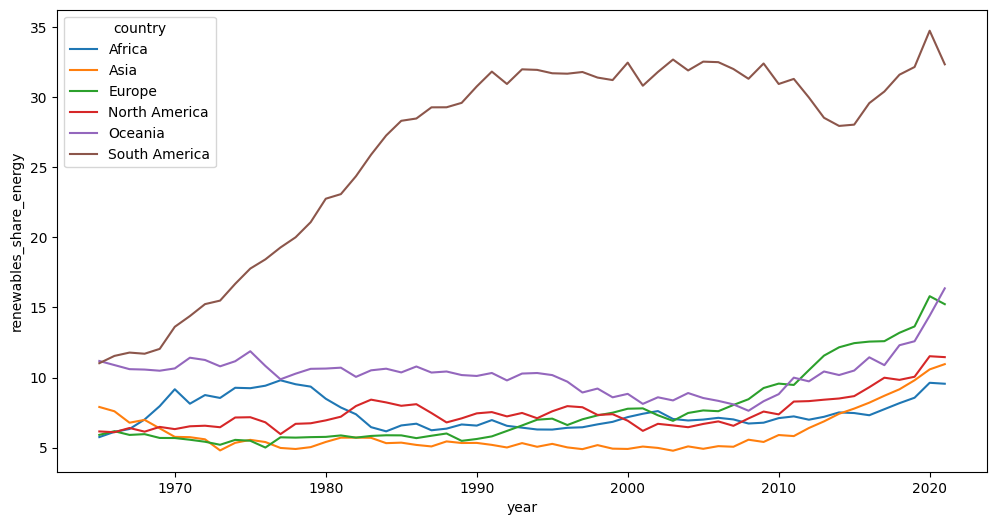

In [13]:
continent_plotting_metrics = ['population', 'greenhouse_gas_emissions', 'fossil_fuel_consumption', 'renewables_consumption', 'fossil_share_energy', 'renewables_share_energy']

for metric in continent_plotting_metrics:
    figure = plt.figure(figsize=(12,6))
    sb.lineplot(data=df1, x = 'year', y = metric, hue = 'country')

## Data Cleaning - filtering of columns for time series forecasting (for continents)

We look at relative data rather than absolute data to make accurate comparisons. Anything that is not normalised by per capita is removed as columns

Percentage change data is removed as it is an extra order of the per capita data.

We remove those with share_energy as they are either subsets of renewables_share_energy or direct derivatives.

In [14]:
# manually extract required columns for now
cols = pd.read_excel('energy_data.xlsx', sheet_name = 'owid-energy-codebook')['columns']
cols = cols[:66]
cols

0                           country
1                              year
2                          iso_code
3                        population
4                               gdp
                  ...              
61                 oil_share_energy
62    other_renewables_share_energy
63               solar_share_energy
64                wind_share_energy
65          renewables_share_energy
Name: columns, Length: 66, dtype: object

In [15]:
# removed the filtered columns accordingly
df1 = df1.loc[:, cols]
df1.head()

country  year iso_code   population  gdp  electricity_share_energy  \
122  Africa  1900      NaN  138827369.0  NaN                       NaN   
123  Africa  1901      NaN  139097937.0  NaN                       NaN   
124  Africa  1902      NaN  139567767.0  NaN                       NaN   
125  Africa  1903      NaN  140074606.0  NaN                       NaN   
126  Africa  1904      NaN  140595545.0  NaN                       NaN   

     energy_cons_change_pct  energy_cons_change_twh  energy_per_capita  \
122                     NaN                     NaN                NaN   
123                     NaN                     NaN                NaN   
124                     NaN                     NaN                NaN   
125                     NaN                     NaN                NaN   
126                     NaN                     NaN                NaN   

     energy_per_gdp  ...  fossil_share_energy  gas_share_energy  \
122             NaN  ...                  NaN               NaN   
123             NaN  ...                  NaN               NaN   
124             NaN  ...                  NaN               NaN   
125             NaN  ...                  NaN               NaN   
126             NaN  ...                  NaN               NaN   

     hydro_share_energy  low_carbon_share_energy  nuclear_share_energy  \
122                 NaN                      NaN                   NaN   
123                 NaN                      NaN                   NaN   
124                 NaN                      NaN                   NaN   
125                 NaN                      NaN                   NaN   
126                 NaN                      NaN                   NaN   

     oil_share_energy  other_renewables_share_energy  solar_share_energy  \
122               NaN                            NaN                 NaN   
123               NaN                            NaN                 NaN   
124               NaN                            NaN                 NaN   
125               NaN                            NaN                 NaN   
126               NaN                            NaN                 NaN   

     wind_share_energy  renewables_share_energy  
122                NaN                      NaN  
123                NaN                      NaN  
124                NaN                      NaN  
125                NaN                      NaN  
126                NaN                      NaN  

[5 rows x 66 columns]

In [16]:
# main focus is on renewables_share_energy and we check what's the earliest year prior to NaN values
df1[['year', 'renewables_share_energy']][~df1['renewables_share_energy'].isnull()].head()

year  renewables_share_energy
187  1965                    5.747
188  1966                    6.122
189  1967                    6.326
190  1968                    7.005
191  1969                    7.956

In [17]:
# the year 1965 is the earliest year whereby renewables_share_energy is not null - and all values afterwards are not null. Hence, we reduce the yearly intervals to 1965 onwards
df1 = df1[df1['year'] >= 1965]

# we check for columns with no null values
df1.isnull().sum().sort_values().head(30)

country                                0
oil_share_energy                       0
low_carbon_share_energy                0
hydro_share_energy                     0
gas_share_energy                       0
fossil_share_energy                    0
coal_share_energy                      0
oil_prod_per_capita                    0
nuclear_elec_per_capita                0
hydro_elec_per_capita                  0
gas_prod_per_capita                    0
coal_prod_per_capita                   0
renewables_energy_per_capita           0
oil_energy_per_capita                  0
low_carbon_energy_per_capita           0
hydro_energy_per_capita                0
low_carbon_elec_per_capita             0
fossil_energy_per_capita               0
year                                   0
population                             0
gas_energy_per_capita                  0
energy_per_capita                      0
renewables_share_energy                0
coal_cons_per_capita                   0
energy_cons_chan

Observing the columns further, we make do with the columns with 0 null values and drop the remaining ones (regardless of whether they have 1 or all null values). Rationale is most of the columns are correlated and are derivatives of one another, so we pick the one with readily accessible data.

Visual observation of data such as wind energy and solar energy are mostly zeroes for majority of the time series, hence they can be dropped as well.

In [18]:
df1 = df1.dropna(axis=1)
print(df1.columns)

Index(['country', 'year', 'population', 'energy_per_capita',
       'coal_cons_per_capita', 'fossil_energy_per_capita',
       'gas_energy_per_capita', 'hydro_energy_per_capita',
       'low_carbon_energy_per_capita', 'oil_energy_per_capita',
       'renewables_energy_per_capita', 'coal_prod_per_capita',
       'gas_prod_per_capita', 'hydro_elec_per_capita',
       'low_carbon_elec_per_capita', 'nuclear_elec_per_capita',
       'oil_prod_per_capita', 'coal_share_energy', 'fossil_share_energy',
       'gas_share_energy', 'hydro_share_energy', 'low_carbon_share_energy',
       'oil_share_energy', 'renewables_share_energy'],
      dtype='object')


C:\Users\bklec\AppData\Local\Temp\ipykernel_9864\4027221973.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

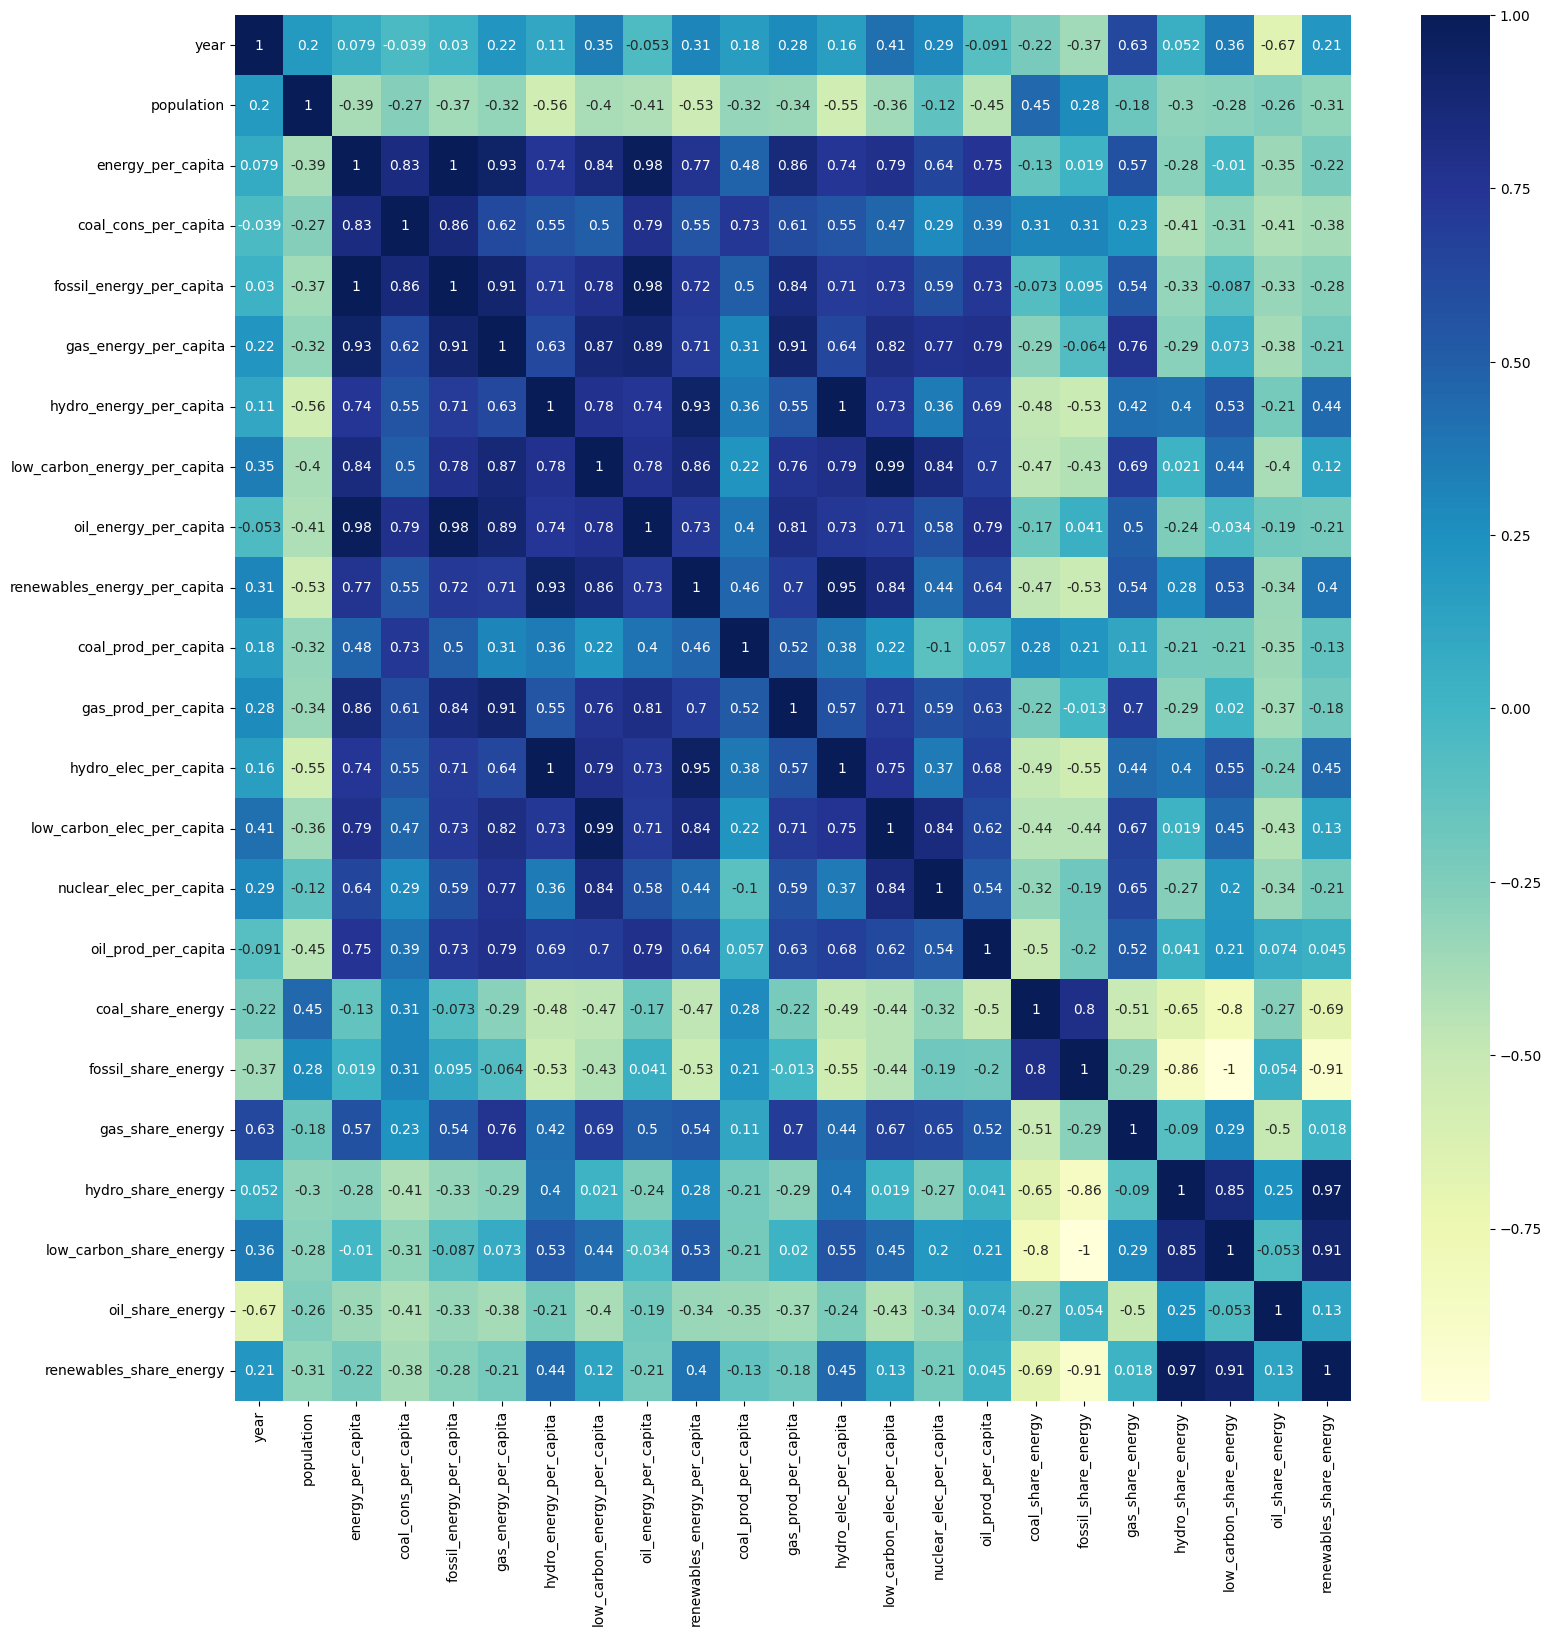

In [19]:
plt.figure(figsize=(18,18))
sb.heatmap(df1.corr(), cmap="YlGnBu", annot=True)

We take those with coefficients that are more than 0.3 to narrow down the variables that we are going to include in our time series. In addition, we omit those that are directly related to renewables_share_energy such as renewables_energy_per_capita.

We decide to omit **fossil_share_energy** as it is directly related to renewables_share_energy which does not make sense to use it to predict renewables_share_energy.

Hence, we narrow the columns down to: **"coal_cons_per_capita", "hydro_energy_per_capita", "hydro_elec_per_capita", "coal_share_energy", "hydro_share_energy" and "low_carbon_share_energy"**


<Axes: >

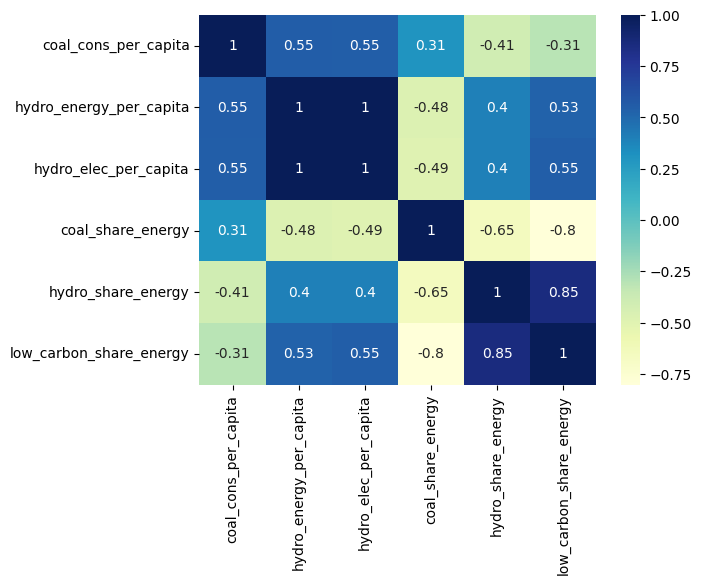

In [20]:
vars = ["coal_cons_per_capita","hydro_energy_per_capita", "hydro_elec_per_capita", "coal_share_energy", "hydro_share_energy", "low_carbon_share_energy"]
sb.heatmap(df1.loc[:,vars].corr(), cmap="YlGnBu", annot=True)

We note that the following pairs are highly correlated and their corresponding correlation coefficients to renewables_share_energy:

1. hydro_energy_per_capita (0.44) and hydro_elec_per_capita (0.45)
2. hydro_share_energy (0.97) and low_carbon_share_energy (0.91)

This is because each pair are subsets of one another which can cause multicollinearity. Hence we decided to select them based on how closely related they are to renewables_share_energy.

This further narrows down to: **"coal_cons_per_capita", "hydro_elec_per_capita", "coal_share_energy", "hydro_share_energy"**

<Axes: >

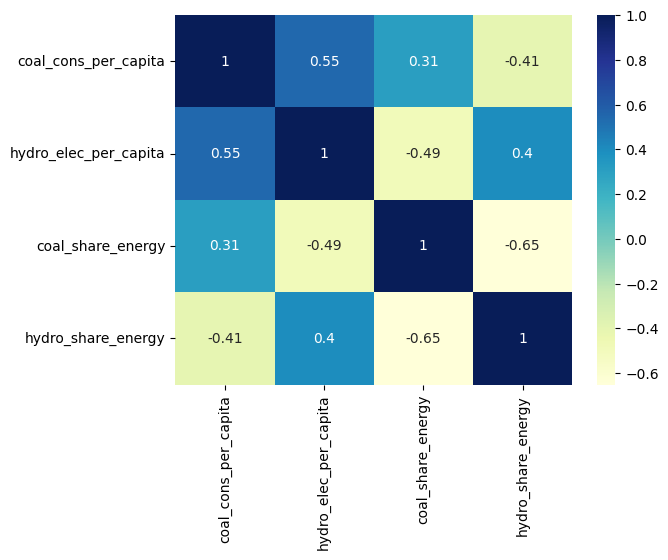

In [21]:
vars1 = ["coal_cons_per_capita", "hydro_elec_per_capita", "coal_share_energy", "hydro_share_energy"]
sb.heatmap(df1.loc[:,vars1].corr(), cmap="YlGnBu", annot=True)

As "coal_cons_per_capita" and "coal_share_energy" as well as "hydro_share_energy" and "hydro_elec_per_capita" are similar in nature, we use **coal_cons_per_capita and hydro_elec_per_capita** as our extra variables in the multi-variate time-series

In [103]:
fvars = ["coal_cons_per_capita", "hydro_elec_per_capita"]
df2 = df1[['country','year', 'renewables_share_energy'] + fvars]
df2.head()

country  year  renewables_share_energy  coal_cons_per_capita  \
187  Africa  1965                    5.747              1006.374   
188  Africa  1966                    6.122               980.173   
189  Africa  1967                    6.326               976.732   
190  Africa  1968                    7.005               990.007   
191  Africa  1969                    7.956               973.523   

     hydro_elec_per_capita  
187                 43.259  
188                 47.049  
189                 47.879  
190                 54.580  
191                 62.069

In [104]:
# we use europe to visualise the columns against renewables_share_energy
sketch = df2[df2['country'] == 'South America']
x = sketch['year']
y1 = sketch['renewables_share_energy']

for column in fvars:    
    y2 = sketch[column]

    # Plot Line1 (Left Y Axis)
    fig, ax1 = plt.subplots(1,1,figsize=(12,6), dpi= 80)
    ax1.plot(x, y1, color='green')

    # Plot Line2 (Right Y Axis)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(x, y2, color='red')

    # Decorations
    # ax1 (left Y axis)
    ax1.set_xlabel('Year', fontsize=15)
    ax1.tick_params(axis='x', rotation=0, labelsize=20)
    ax1.set_ylabel('Renewables as share of total energy', color='green', fontsize=15)
    ax1.tick_params(axis='y', rotation=0, labelcolor='green' )
    ax1.grid(alpha=.4)

    # ax2 (right Y axis)
    ax2.set_ylabel(f"{column}", color='red', fontsize=15)
    ax2.tick_params(axis='y', labelcolor='red')
    fig.tight_layout()
    plt.show()

In [174]:
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sa_df = df2[df2['country'] == 'South America'].reset_index().drop(columns='index')
sa_df.head()

country  year  renewables_share_energy  coal_cons_per_capita  \
0  South America  1965                   11.023               390.287   
1  South America  1966                   11.543               384.263   
2  South America  1967                   11.781               397.063   
3  South America  1968                   11.698               371.548   
4  South America  1969                   12.044               394.940   

   hydro_elec_per_capita  
0                231.868  
1                251.778  
2                259.803  
3                269.281  
4                283.523

renewables_share_energy 1st order differencing p-value: 0.12438144333833184
renewables_share_energy 2nd order differencing p-value: 0.00065375611366154
coal_cons_per_capita 1st order differencing p-value: 1.3991622332008482e-13
coal_cons_per_capita 2nd order differencing p-value: 2.0010007139136424e-11
hydro_elec_per_capita 1st order differencing p-value: 0.9654472004471152
hydro_elec_per_capita 2nd order differencing p-value: 0.0015718709855125467


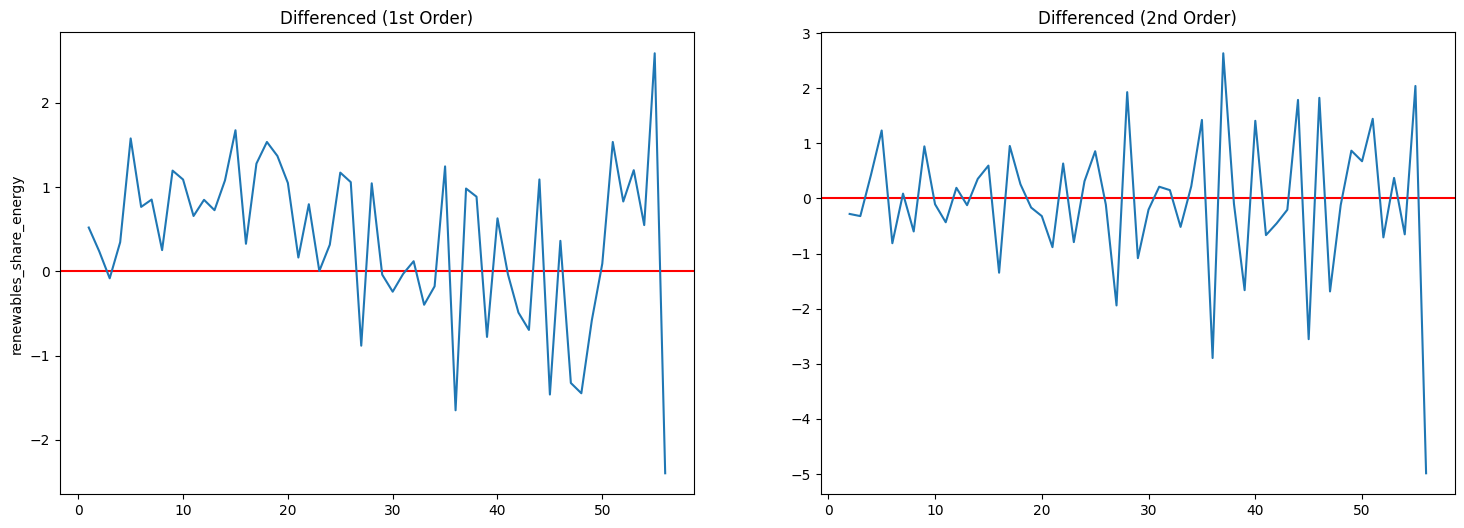

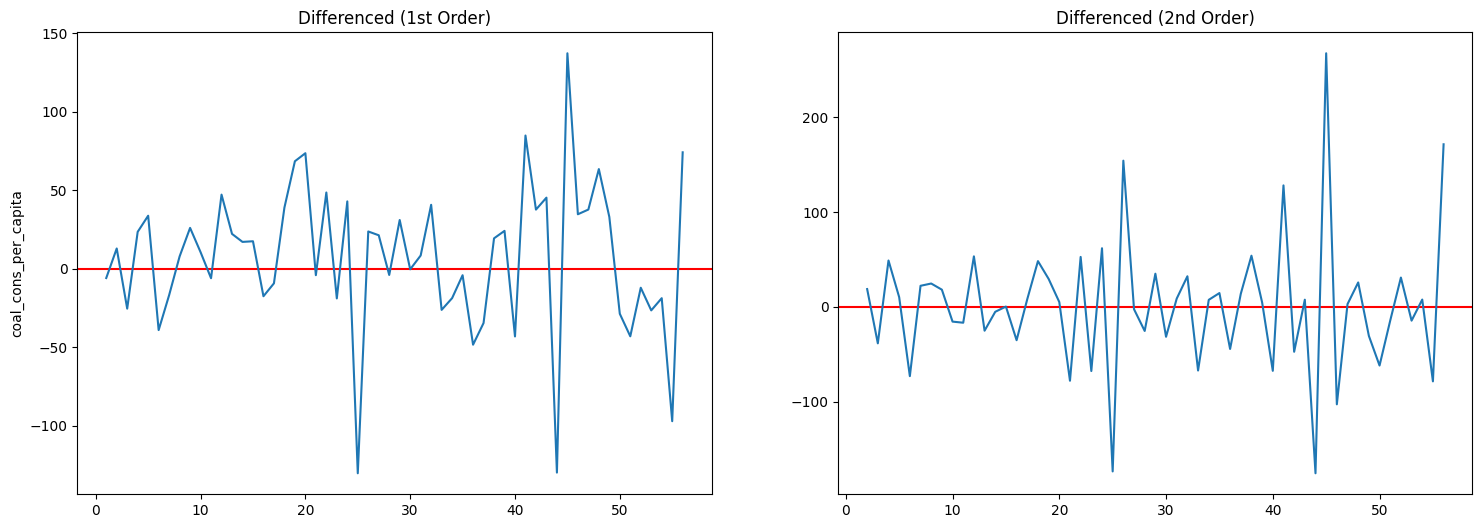

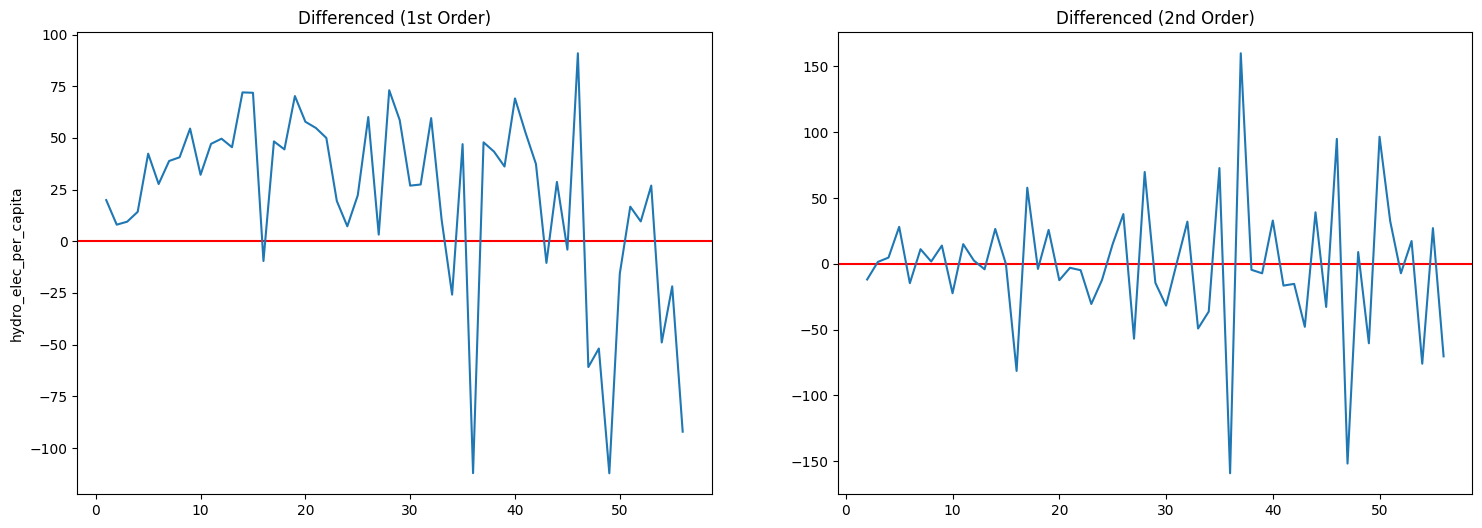

In [175]:
sa_vars = sa_df[['renewables_share_energy', 'coal_cons_per_capita', 'hydro_elec_per_capita']]
sa_diff1 = sa_vars.diff().dropna()

for column in sa_diff1.columns:
    fig, ax = plt.subplots(1, 2, figsize=(18,6))
    ax[0].set_ylabel(f"{column}")
    ax[0].axhline(y=0, c='red')
    ax[1].axhline(y=0, c='red')

    # first order differencing
    sa_diff1[column].plot(ax=ax[0])
    result = adfuller(sa_diff1[column])
    print(f'{column} 1st order differencing p-value: {result[1]}')
    
    # second order differencing
    sa_diff2 = sa_diff1.diff().dropna()
    sa_diff2[column].plot(ax=ax[1])
    result = adfuller(sa_diff2[column])
    print(f'{column} 2nd order differencing p-value: {result[1]}')
    
    ax[0].set_title('Differenced (1st Order)')
    ax[1].set_title('Differenced (2nd Order)')

It seems that all columns should be **differenced twice** - we ignore the sharp drop towards the end of renewables_share_energy as it can be accounted for later on

We now concatenate the 2nd order differenced data to sa_df and plot their respective ACF and PACF plots

In [238]:
# second order differencing on all 3 columns
for vars in sa_vars:
    sa_diff = sa_df[vars].diff().dropna().diff().dropna()
    sa_df[f'{vars}_diff'] = sa_diff

sa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       57 non-null     object 
 1   year                          57 non-null     int64  
 2   renewables_share_energy       57 non-null     float64
 3   coal_cons_per_capita          57 non-null     float64
 4   hydro_elec_per_capita         57 non-null     float64
 5   renewables_share_energy_diff  55 non-null     float64
 6   coal_cons_per_capita_diff     55 non-null     float64
 7   hydro_elec_per_capita_diff    55 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 3.7+ KB


c:\Users\bklec\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



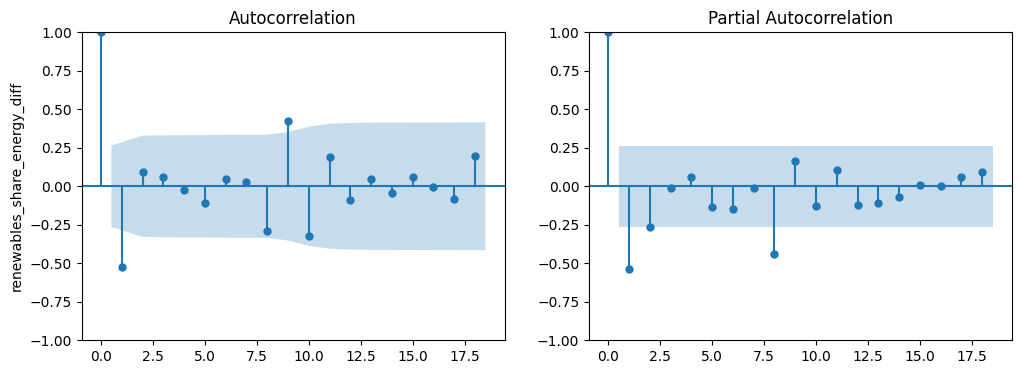

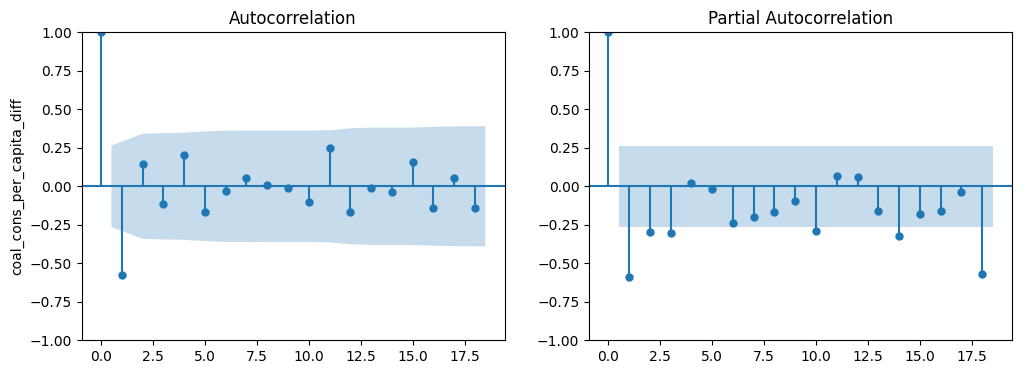

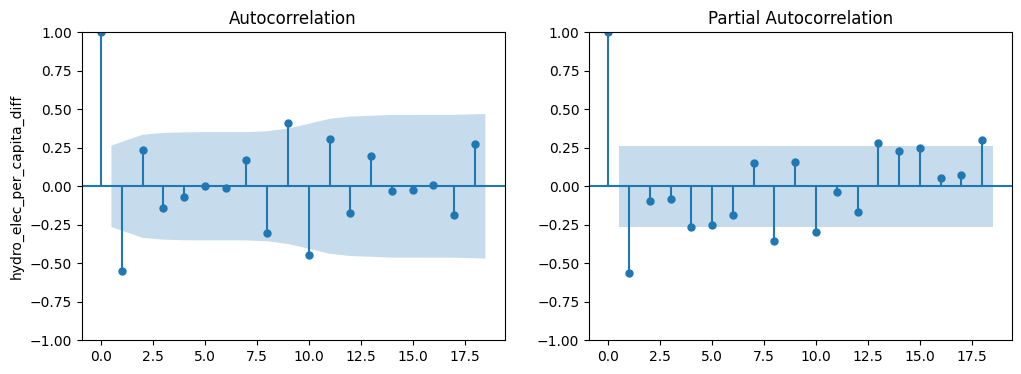

In [177]:
# plotting of acf and pacf plots for differenced series
for col in sa_df.columns[5::]:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].set_ylabel(f"{col}")
    acf_diff = plot_acf(sa_df[col].dropna(), ax=ax[0])
    pacf_diff = plot_pacf(sa_df[col].dropna(), ax=ax[1])

To figure out how to get parameter **p** which is the auto-regressive portion, we look at the PACF

To figure out how to get parameter **q** which is the moving average portion, we look at the ACF

1. renewables_share_energy: 
- ACF - spikes at lag 1 and 9
- PACF - spikes at lag 1 and 8

2. coal_cons_per_capita
- ACF - spike at lag 1
- PACF - spikes at lags 1, 2, 3, 10, 14 and 18

3. hydro_elec_per_capita
- ACF - spikes at lags 1, 9 and 10
- PACF - spikes at lags 1 8, 10 and 18

We will use a multivariate ARIMA model to model renewables_share_energy as we observe that the 2nd order differenced data have no seasonality.

We start off with a simple ARIMA (1,2,1) model as we do not want to complicate the model initially - i.e. take the first significant spike for both ACF (q) and PACF (p) plots

In [178]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(sa_df['renewables_share_energy'], order=(1,2,1))
model_fit = model.fit()

# we check the summary columns for coef (to be non-zero) and P >|z| to be less than 0.05
print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     renewables_share_energy   No. Observations:                   57
Model:                      ARIMA(1, 2, 1)   Log Likelihood                 -73.975
Date:                     Mon, 03 Apr 2023   AIC                            153.949
Time:                             23:01:15   BIC                            159.971
Sample:                                  0   HQIC                           156.278
                                      - 57                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3420      0.161     -2.130      0.033      -0.657      -0.027
ma.L1         -0.7122      0.098     -7.288      0.000      -0.904      -0.521
sigma2      

<Axes: title={'center': 'Density'}, ylabel='Density'>

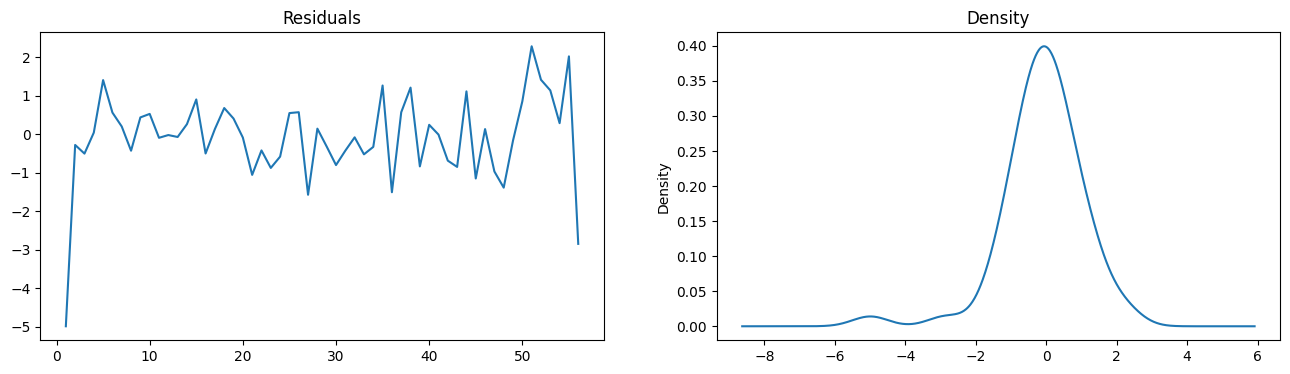

In [179]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2, figsize=(16,4))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])

In [180]:
model1 = ARIMA(sa_df['coal_cons_per_capita'], order=(1,1,1))
model1_fit = model1.fit()

# we check the summary columns for coef (to be non-zero) and P >|z| to be less than 0.05
print(model1_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     coal_cons_per_capita   No. Observations:                   57
Model:                   ARIMA(1, 1, 1)   Log Likelihood                -294.633
Date:                  Mon, 03 Apr 2023   AIC                            595.266
Time:                          23:01:15   BIC                            601.342
Sample:                               0   HQIC                           597.621
                                   - 57                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7304      0.477     -1.530      0.126      -1.666       0.205
ma.L1          0.5954      0.556      1.070      0.284      -0.495       1.686
sigma2      2172.6928    410.148    

<Axes: title={'center': 'Density'}, ylabel='Density'>

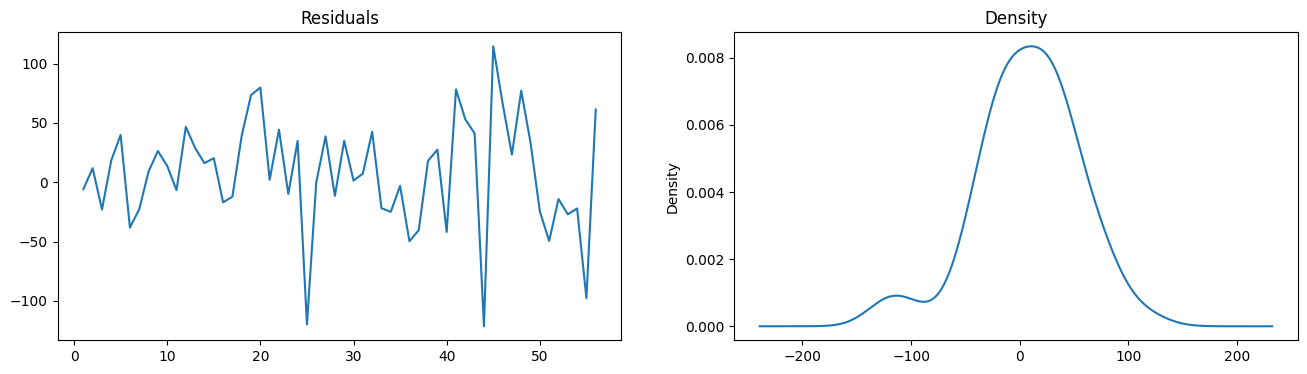

In [181]:
residuals1 = model1_fit.resid[1:]
fig, ax = plt.subplots(1,2, figsize=(16,4))
residuals1.plot(title='Residuals', ax=ax[0])
residuals1.plot(title='Density', kind='kde', ax=ax[1])

In [260]:
model2 = ARIMA(sa_df['hydro_elec_per_capita'], order=(0,2,1))
model2_fit = model2.fit()

# we check the summary columns for coef (to be non-zero) and P >|z| to be less than 0.05
print(model2_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     hydro_elec_per_capita   No. Observations:                   57
Model:                    ARIMA(0, 2, 1)   Log Likelihood                -283.427
Date:                   Mon, 03 Apr 2023   AIC                            570.854
Time:                           23:57:33   BIC                            574.868
Sample:                                0   HQIC                           572.406
                                    - 57                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8079      0.092     -8.812      0.000      -0.988      -0.628
sigma2      1718.9035    263.506      6.523      0.000    1202.441    2235.366
Ljung-Box (L1) (Q):         

<Axes: title={'center': 'Density'}, ylabel='Density'>

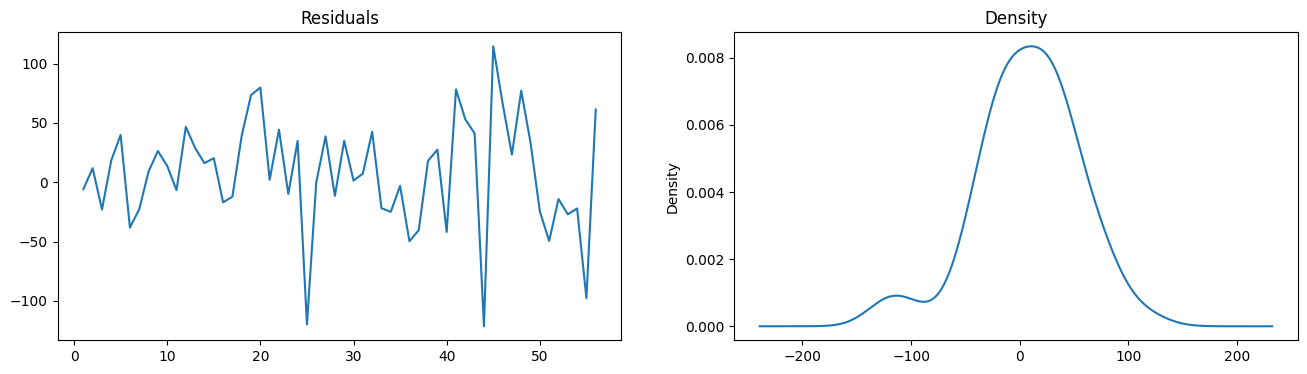

In [183]:
residuals2 = model1_fit.resid[1:]
fig, ax = plt.subplots(1,2, figsize=(16,4))
residuals2.plot(title='Residuals', ax=ax[0])
residuals2.plot(title='Density', kind='kde', ax=ax[1])

We see that it is reasonably stationary and usable for an ARIMA modelling for (1,2,1). We will initialise the ARIMA model first and check back on how to tweak it afterwards.

In [288]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# make year the index of sa_df
sa_df1 = sa_df.set_index('year').drop(['coal_cons_per_capita_diff', 'renewables_share_energy_diff', 'hydro_elec_per_capita_diff'], axis=1)

# Split the data into training and testing sets - cut-off year is 2015
train_data = sa_df1.loc[:'2017']
test_data = sa_df1.loc['2017':]

# fit univariate ARIMA models to each of the other two columns
# select the best hyperparameters based on the AIC
model_coal = ARIMA(train_data['coal_cons_per_capita'], order=(1, 2, 1)).fit()
model_hydro = ARIMA(train_data['hydro_elec_per_capita'], order=(1, 2, 1)).fit()

# combine the three columns into a single dataframe, using the training set only
train_data_combined = pd.concat([train_data['renewables_share_energy'], model_coal.fittedvalues, model_hydro.fittedvalues], axis=1)
train_data_combined.columns = ['renewables_share_energy', 'coal_cons_per_capita', 'hydro_elec_per_capita']

# Fit a multivariate ARIMA model to the combined data
model = SARIMAX(train_data_combined['renewables_share_energy'], exog=train_data_combined.iloc[:, 1:], order=(1, 2, 1))
results = model.fit()

# use the fitted model to make predictions on the testing set
test_data_combined = pd.concat([test_data['renewables_share_energy'], test_data['coal_cons_per_capita'], test_data['hydro_elec_per_capita']], axis=1)
test_data_combined.columns = ['renewables_share_energy', 'coal_cons_per_capita', 'hydro_elec_per_capita']
exog_test = test_data_combined.iloc[:, 1:]
predictions = results.predict(exog=exog_test)

mse = mean_squared_error(train_data['renewables_share_energy'], predictions)
print(f"Mean Squared Error: {mse}")

sa_df1['predictions'] = predictions
sa_df1[['renewables_share_energy', 'predictions']].plot(ylabel = 'renewables_share_energy', figsize=(12,6))

Mean Squared Error: 3.2873178378881294


<Axes: xlabel='year', ylabel='renewables_share_energy'>

In [293]:
forecast_test = results.forecast(len(test_data_combined['renewables_share_energy']), exog=exog_test)
sa_df1['forecast_test'] = [None]*(len(train_data) - 1) + list(forecast_test)
sa_df1[['renewables_share_energy', 'forecast_test']].plot(ylabel = 'renewables_share_energy', figsize=(12,6))

<Axes: xlabel='year', ylabel='renewables_share_energy'>

## Machine Learning - Auto Regressive Integrated Moving Average

Broken down into 3 parameters with non-negative integer values:

1. Auto Regressive (p)

    - time series is linearly regressed on its own past values

    - p is the number of past values included in the AR model

2. Integrated (d)

    - if not stationary, time series has to be differenced to become stationary (i.e. compute the difference between consecutive observations)

    - d is the number of times the time series is differenced
    
3. Moving Average (q)

    - time series is regressed based on the past forecast errors
    
    - q is the number of past forecast errors in the MA model

https://www.youtube.com/watch?v=-aCF0_wfVwY

### Exploring the data

Reduce time variance by taking logarithm - but don't forget to transform back when making real predictions

Split into training and test set - training data can be before 2000, test data can be 2000 to 2019 (Removed 2020 due to COVID-19 pandemic affecting energy consumption - black swan event)

### Check for stationarity of time series

Tell by looking at the plots - energy trends is decreasing for renewables

**ACF** - correlation of time series with its lags (y(t) and y(t-k) for k = 1, 2..)

Problem is y(t) is related to y(t-1) which is related to y(t-2). So how do we measure if there is new info in y(t-2) to predict y(t) beside their relationship with y(t-1)?

Hence, we use **PACF** - partial correlation of time series with its lags AFTER removing the lower-order-lags between them

We can use statistical tests like **ADF** which stands for Augmented Dickey Fuller.

ADF tests for the null hypothesis that there is a unit root (i.e. non-stationary). Stationarity would mean a small p-value (<0.05).

### Transform time series to be stationary - Differencing

Helps to stabilise the mean by removing changes in levels of the series (current observation - previous observation)

Use .diff().dropna() on the training dataset - dropna() is used to remove first observation since it has nothing to subtract.

Replot ACF, PACF and ADF to see if it can be considered as stationary - usually do not go beyond 2nd order differencing.

Determine the differencing and continue to find p and q with the differenced training data.

### Determine parameters p and q

If PACF plot has a significant spike at lag p, but not beyond - ACF plot decays more gradually -> q can be considered to be 0

If ACF plot has a significant spike at lag q, but not beyond - PACF plot decays more gradually -> p can be considered to be 0

### Fit the ARIMA model

After fitting, use residuals (model_fit.resid[1:]) to check that it should be random like white noise. Density must be normally-distributed.

ACF and PACF should have no significant spikes as well.

### Other suggestions

Time series cross validation to select the best model

## Europe's ARIMA model

In [25]:
# Start with one continent data first - Europe's renewable share of energy usage
eu = continent_data[continent_data['country'] == 'Europe'][['year', 'renewables_share_energy']].dropna().reset_index().drop(columns='index')
eu.plot(x = 'year', y = 'renewables_share_energy')
plt.title('Renewables as share of total energy (Europe)');

NameError: name 'continent_data' is not defined

In [ ]:
# split into training and test sets
# rationale is trend changes towards the more recent years which we want to capture in our model
eu_train = eu[eu['year'] < 2015].copy()
eu_test = eu[~(eu['year'] < 2015)].copy()
print(f'Training Data: {len(eu_train)}')
print(f'Test Data: {len(eu_test)}')

Training Data: 50
Test Data: 7


In [ ]:
# plot ACF and PACF plot on un-differenced data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1,2, figsize=(12,4))
acf_original = plot_acf(eu_train['renewables_share_energy'], ax=ax[0])
pacf_original = plot_pacf(eu_train['renewables_share_energy'], ax=ax[1])

# check ADF test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(eu_train['renewables_share_energy'])
print(f'p-value: {adf_test[1]}')

c:\Users\bklec\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



p-value: 1.0


Time series appears to be non-stationary and p-value is high for the Augmented Dickey-Fuller test. Hence we difference the data once and twice and compare their stationarity.

In [ ]:
# first order differencing
eu_train_diff1 = eu_train['renewables_share_energy'].diff().dropna()
eu_train['renewables_share_energy_diff1'] = np.append([0], eu_train_diff1)

# second order differencing
eu_train_diff2 = eu_train_diff1.diff().fillna(0)
eu_train['renewables_share_energy_diff2'] = np.append([0], eu_train_diff2)

f, ax = plt.subplots(1,2, figsize=(16,4))
eu_train_diff1.plot(ax=ax[0])
eu_train_diff2.plot(ax=ax[1])
ax[0].set_title('Differenced (1st Order)')
ax[1].set_title('Differenced (2nd Order)')

# adf test for 1st and 2nd differencing
adf_train_diff1 = adfuller(eu_train_diff1)
adf_train_diff2 = adfuller(eu_train_diff2)

print(f'p-value for 1st differencing: {adf_train_diff1[1]}')
print(f'p-value for 2nd differencing: {adf_train_diff2[1]}')

p-value for 1st differencing: 7.22487362504044e-06
p-value for 2nd differencing: 1.4851574304389108e-06


c:\Users\bklec\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



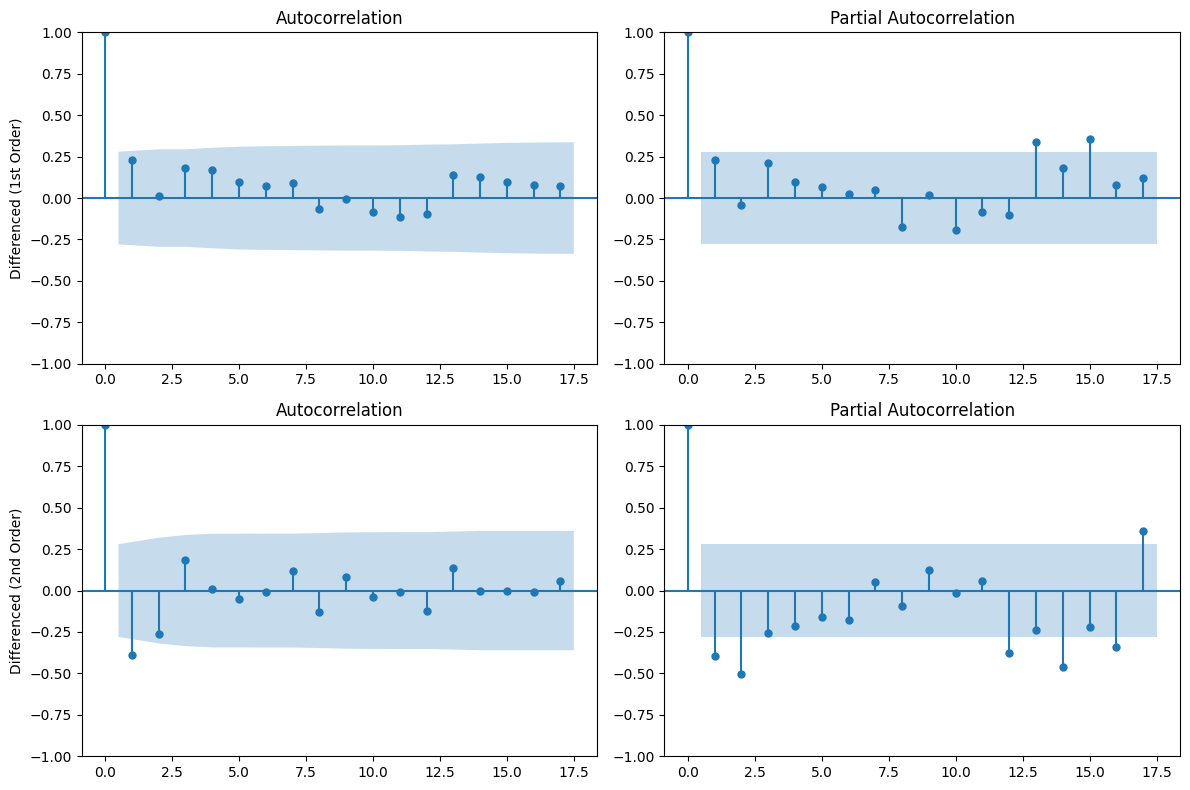

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
acf_diff1 = plot_acf(eu_train_diff1, ax=ax[0,0])
pacf_diff1 = plot_pacf(eu_train_diff1, ax=ax[0,1])
ax[0,0].set_ylabel('Differenced (1st Order)')

acf_diff2 = plot_acf(eu_train_diff2, ax=ax[1,0])
pacf_diff2 = plot_pacf(eu_train_diff2, ax=ax[1,1])
ax[1,0].set_ylabel('Differenced (2nd Order)')
plt.tight_layout()

We will use the 1st order differenced data as there is not much significant improvement when differencing to 2nd order

p-value rejects null hypothesis for ADF test and PACF & ACF plots show a sharp drop after lag 1.

We fit the ARIMA model of (1,1,1) into our training dataset.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(eu_train['renewables_share_energy'], order=(1,1,1))
model_fit = model.fit()

# we check the summary columns for coef (to be non-zero) and P >|z| to be less than 0.05
print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     renewables_share_energy   No. Observations:                   50
Model:                      ARIMA(1, 1, 1)   Log Likelihood                 -17.908
Date:                     Sun, 02 Apr 2023   AIC                             41.815
Time:                             00:35:42   BIC                             47.491
Sample:                                  0   HQIC                            43.969
                                      - 50                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9715      0.118      8.231      0.000       0.740       1.203
ma.L1         -0.8059      0.207     -3.898      0.000      -1.211      -0.401
sigma2      

<Axes: title={'center': 'Density'}, ylabel='Density'>

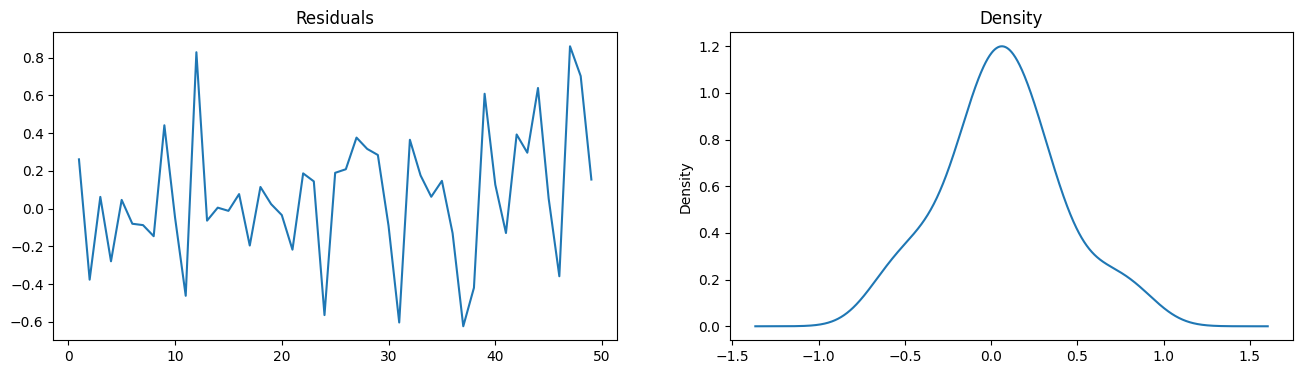

In [ ]:
# we check the residuals and density distribution of the model - residuals should look like white noise and density should be normal
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2, figsize=(16,4))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])

<Axes: >

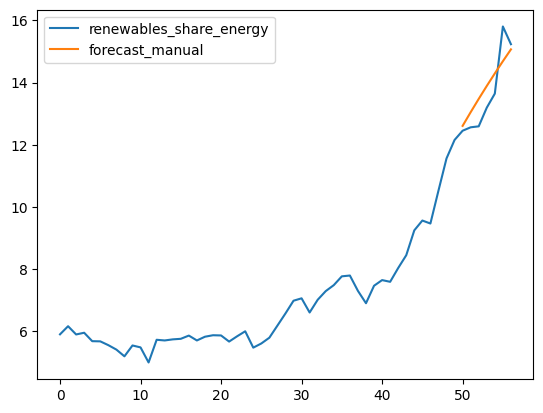

In [ ]:
forecast_test = model_fit.forecast(len(eu_test['renewables_share_energy']))
eu['forecast_manual'] = [None]*len(eu_train) + list(forecast_test)
eu[['renewables_share_energy', 'forecast_manual']].plot()

In [ ]:
# we check the statistical errors of our model
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(eu_test['renewables_share_energy'], forecast_test)
mape = mean_absolute_percentage_error(eu_test['renewables_share_energy'], forecast_test)
rmse = np.sqrt(mean_squared_error(eu_test['renewables_share_energy'], forecast_test))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

mae: 0.5937549818777865
mape: 0.04334545062295447
rmse: 0.6787789842902036


In [ ]:
import pmdarima as pm
auto_arima = pm.auto_arima(eu_train['renewables_share_energy'], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(2, 2, 1), scoring_args={}, suppress_warnings=True)

In [ ]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   50
Model:               SARIMAX(2, 2, 1)   Log Likelihood                 -15.504
Date:                Sun, 02 Apr 2023   AIC                             41.007
Time:                        00:35:47   BIC                             50.363
Sample:                             0   HQIC                            44.543
                                 - 50                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0199      0.014      1.446      0.148      -0.007       0.047
ar.L1         -0.0938      0.184     -0.509      0.611      -0.455       0.268
ar.L2         -0.2788      0.201     -1.388      0.165      -0.672       0.115
ma.L1         -0.7485      0.168     -4.448      0.000      -1.078      -0.419
sigma2         0.1085      0.024      4.596      0.000       0.062       0.155
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.94   Prob(JB):                         0.98
Heteroskedasticity (H):               1.71   Skew:                             0.07
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

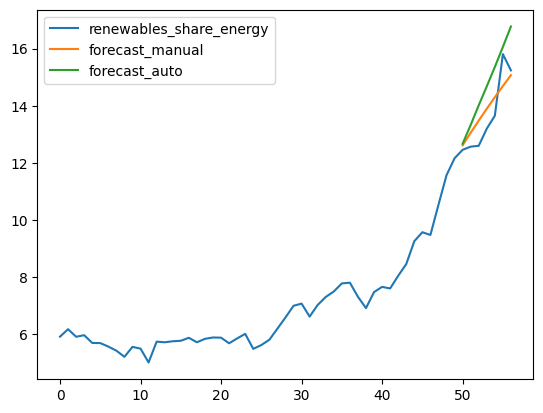

In [ ]:
# compare manual vs auto ARIMA modelling
forecast_test_auto = auto_arima.predict(n_periods=len(eu_test))
eu['forecast_auto'] = [None]*len(eu_train) + list(forecast_test_auto)
eu[['renewables_share_energy', 'forecast_manual', 'forecast_auto']].plot()

### For Europe's renewables_share_energy, we use ARIMA (1,1,1) for forecassting (manually determined)

## Asia's ARIMA model

<Axes: xlabel='year'>

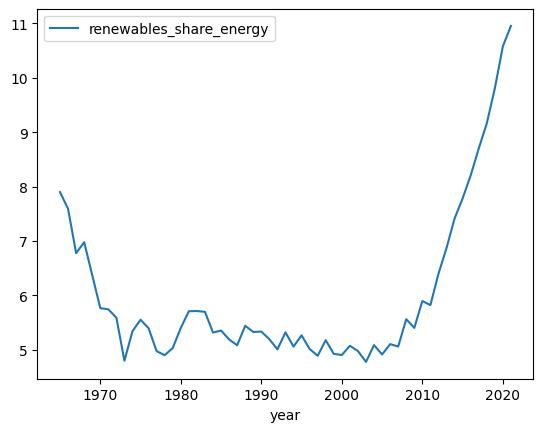

In [ ]:
# initialise renewables for asia
asia = continent_data[continent_data['country'] == 'Asia'][['year', 'renewables_share_energy']].dropna().reset_index().drop(columns='index')
asia.plot(x = 'year', y = 'renewables_share_energy')

In [ ]:
# determine train-test split and acf/pacf
asia_train = asia[asia['year'] < 2015].copy()
asia_test = asia[~(asia['year'] < 2015)].copy()
print(f'Training Data: {len(asia_train)}')
print(f'Test Data: {len(asia_test)}')

Training Data: 50
Test Data: 7


In [ ]:
# we skip the plotting of initial training data as we know it needs to be stationarised
# first order differencing
asia_train_diff1 = asia_train['renewables_share_energy'].diff().dropna()
asia_train['renewables_share_energy_diff1'] = np.append([0], asia_train_diff1)

# second order differencing
asia_train_diff2 = asia_train_diff1.diff().fillna(0)
asia_train['renewables_share_energy_diff2'] = np.append([0], asia_train_diff2)

f, ax = plt.subplots(1,2, figsize=(16,4))
asia_train_diff1.plot(ax=ax[0])
asia_train_diff2.plot(ax=ax[1])
ax[0].set_title('Differenced (1st Order)')
ax[1].set_title('Differenced (2nd Order)')

# ADF tests for 1st and 2nd order differencing
adf_train_diff1 = adfuller(asia_train_diff1)
adf_train_diff2 = adfuller(asia_train_diff2)

print(f'p-value for 1st differencing: {adf_train_diff1[1]}')
print(f'p-value for 2nd differencing: {adf_train_diff2[1]}')

p-value for 1st differencing: 0.0017173397025387737
p-value for 2nd differencing: 5.992164840467958e-07


In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
acf_diff1 = plot_acf(asia_train_diff1, ax=ax[0,0])
pacf_diff1 = plot_pacf(asia_train_diff1, ax=ax[0,1])
ax[0,0].set_ylabel('Differenced (1st Order)')

acf_diff2 = plot_acf(asia_train_diff2, ax=ax[1,0])
pacf_diff2 = plot_pacf(asia_train_diff2, ax=ax[1,1])
ax[1,0].set_ylabel('Differenced (2nd Order)')
plt.tight_layout()

c:\Users\bklec\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



We choose the ARIMA model (1,1,1) based on the plots for Asia's renewables share.

In [ ]:
# fit the arima model based on parameters above and look at AIC/BIC - this combination of (p, d, q) gives the lowest AIC/BIC score
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(asia_train['renewables_share_energy'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     renewables_share_energy   No. Observations:                   50
Model:                      ARIMA(1, 1, 1)   Log Likelihood                 -13.991
Date:                     Sun, 02 Apr 2023   AIC                             33.983
Time:                             00:35:49   BIC                             39.658
Sample:                                  0   HQIC                            36.136
                                      - 50                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9495      0.090     10.506      0.000       0.772       1.127
ma.L1         -0.8156      0.191     -4.272      0.000      -1.190      -0.441
sigma2      

In [ ]:
# plot acf and pacf of residuals to check - make sure they are white noise after the first lag
fig, ax = plt.subplots(1,4, figsize=(16,4))

residuals = model_fit.resid[1:]
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
acf_res = plot_acf(residuals, ax=ax[2])
pacf_res = plot_pacf(residuals, ax=ax[3])

c:\Users\bklec\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



mae: 1.1298665864286017
mape: 0.11350941472661914
rmse: 1.3564647331694302


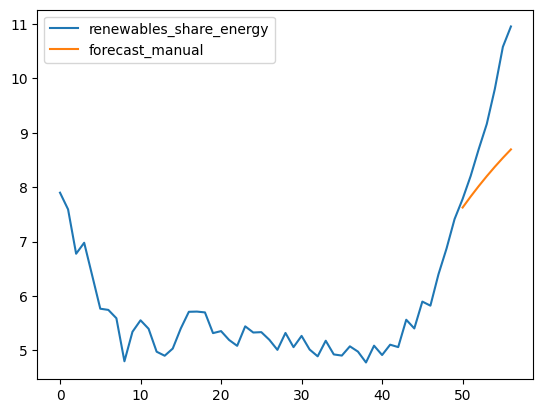

In [ ]:
# look at the manually determined data
forecast_test = model_fit.forecast(len(asia_test['renewables_share_energy']))
asia['forecast_manual'] = [None]*len(asia_train) + list(forecast_test)

asia[['renewables_share_energy', 'forecast_manual']].plot()

mae = mean_absolute_error(asia_test['renewables_share_energy'], forecast_test)
mape = mean_absolute_percentage_error(asia_test['renewables_share_energy'], forecast_test)
rmse = np.sqrt(mean_squared_error(asia_test['renewables_share_energy'], forecast_test))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   50
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -19.000
Date:                Sun, 02 Apr 2023   AIC                             44.001
Time:                        00:35:52   BIC                             49.737
Sample:                             0   HQIC                            46.185
                                 - 50                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.008    126.176      0.000       0.983       1.015
ma.L1          0.0158      0.142      0.111      0.912      -0.263       0.294
sigma2         0.1105      0.025      4.451      0.0

<Axes: >

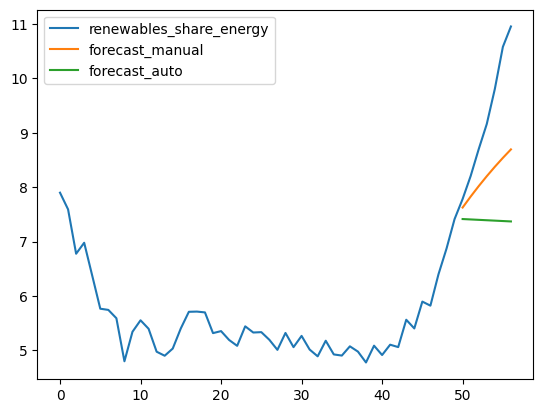

In [ ]:
auto_arima = pm.auto_arima(asia_train['renewables_share_energy'], stepwise=False, seasonal=False)
print(auto_arima.summary())

forecast_test_auto = auto_arima.predict(n_periods=len(asia_test))
asia['forecast_auto'] = [None]*len(asia_train) + list(forecast_test_auto)

asia[['renewables_share_energy', 'forecast_manual', 'forecast_auto']].plot()

### Hence, for Asia's renewables_share_energy, we use an ARIMA model of (2,1,2) for forecasting (manually determined)

## Africa's ARIMA model

<Axes: xlabel='year'>

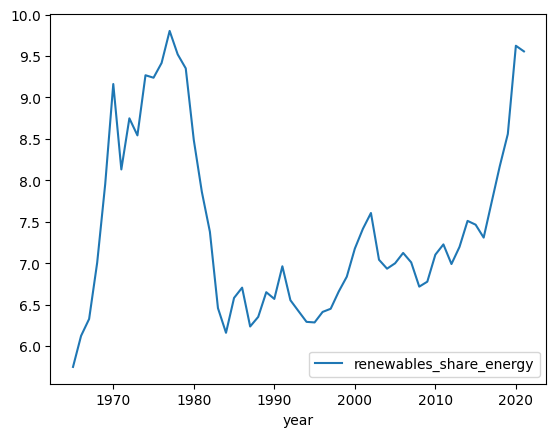

In [ ]:
africa_renew = continent_data[continent_data['country'] == 'Africa'][['year', 'renewables_share_energy']].dropna().reset_index().drop(columns='index')
africa_renew.plot(x = 'year', y = 'renewables_share_energy')

In [ ]:
africa_renew_train = africa_renew[africa_renew['year'] < 2018].copy()
africa_renew_test = africa_renew[~(africa_renew['year'] < 2018)].copy()

fig, ax = plt.subplots(1,2, figsize=(12,4))
acf_original = plot_acf(africa_renew_train['renewables_share_energy'], ax=ax[0])
pacf_original = plot_pacf(africa_renew_train['renewables_share_energy'], ax=ax[1])

adf_test = adfuller(africa_renew_train['renewables_share_energy'])
print(f'p-value: {adf_test[1]}')

c:\Users\bklec\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



p-value: 0.21797308650456426


c:\Users\bklec\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



p-value: 1.264765054707158e-07


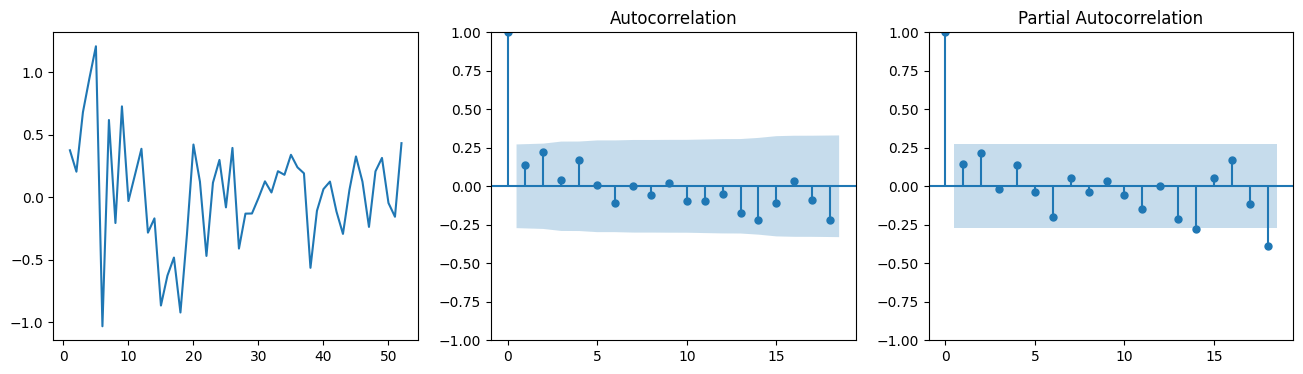

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(16,4))

# adf test insufficient to reject null hypothesis - do first order differencing and plot the data, ACF and PACF
africa_renew_train_diff = africa_renew_train['renewables_share_energy'].diff().dropna()
africa_renew_train_diff.plot(ax=ax[0])

acf_diff = plot_acf(africa_renew_train_diff, ax=ax[1])
pacf_diff = plot_pacf(africa_renew_train_diff, ax=ax[2])

adf_test_diff = adfuller(africa_renew_train_diff)
print(f'p-value: {adf_test_diff[1]}')

In [ ]:
# fit the arima model based on parameters above and look at AIC/BIC - this combination of (p, d, q) gives the lowest AIC/BIC score
model = ARIMA(africa_renew_train['renewables_share_energy'], order=(0,2,1))
model_fit = model.fit()
print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     renewables_share_energy   No. Observations:                   53
Model:                      ARIMA(0, 2, 1)   Log Likelihood                 -30.757
Date:                     Sun, 02 Apr 2023   AIC                             65.513
Time:                             00:35:54   BIC                             69.377
Sample:                                  0   HQIC                            66.990
                                      - 53                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7835      0.082     -9.531      0.000      -0.945      -0.622
sigma2         0.1920      0.027      7.173      0.000       0.140       0.244
Ljung-Box (L

<Axes: >

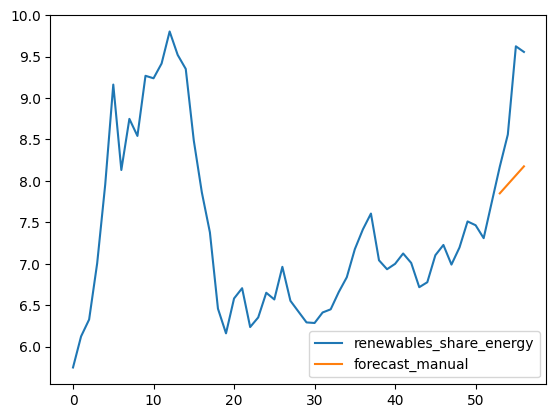

In [ ]:
# look at the manually determined data
forecast_test = model_fit.forecast(len(africa_renew_test['renewables_share_energy']))
africa_renew['forecast_manual'] = [None]*len(africa_renew_train) + list(forecast_test)

africa_renew[['renewables_share_energy', 'forecast_manual']].plot()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 -32.224
Date:                Sun, 02 Apr 2023   AIC                             72.447
Time:                        00:35:56   BIC                             80.328
Sample:                             0   HQIC                            75.478
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9969      0.010    101.755      0.000       0.978       1.016
ma.L1          0.1276      0.112      1.142      0.254      -0.091       0.347
ma.L2          0.1722      0.129      1.336      0.1

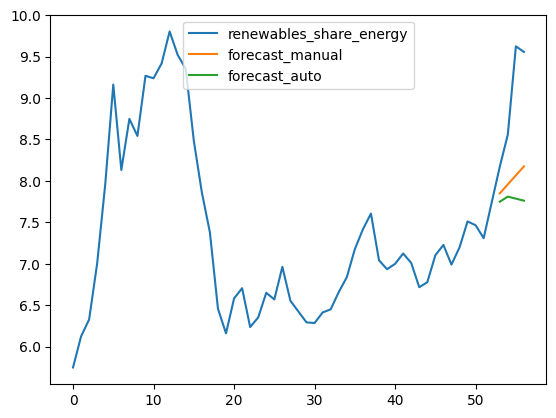

In [ ]:
# compare auto and manually forecasted models
auto_arima = pm.auto_arima(africa_renew_train['renewables_share_energy'], stepwise=False, seasonal=False)
print(auto_arima.summary())

forecast_test_auto = auto_arima.predict(n_periods=len(africa_renew_test))
africa_renew['forecast_auto'] = [None]*len(africa_renew_train) + list(forecast_test_auto)

africa_renew[['renewables_share_energy', 'forecast_manual', 'forecast_auto']].plot()

mae = mean_absolute_error(africa_renew_test['renewables_share_energy'], forecast_test)
mape = mean_absolute_percentage_error(africa_renew_test['renewables_share_energy'], forecast_test)
rmse = np.sqrt(mean_squared_error(africa_renew_test['renewables_share_energy'], forecast_test))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

### Hence, for Africa's renewables_share_energy, we use an ARIMA model of (0,2,1) for forecasting (manually determined)

Note that the test data set is very small as we intended to capture the rapid increase in renewables energy in recent years in Africa.